In [1]:
""" 
SOMMAIRE.

- recupérer les données à partir de la base de données sql : top_gun_data_1.db
- decliner les données par tables : aeronefs, composants, degradations et vols.
- renommer certaines colonnes pour faciliter les jointures au besoin.
- recuprer la date de mise en service de chque avion et l'intégrer à la table des vols.
- calculer les heures de vols cumulées et les stocker des la colonne 'cumulative_hours'
- afficher les hsitogrammes des variables numriques de la table
- affichier la matrice de corrélation des variables numériques.

"""

" \nSOMMAIRE.\n\n- recupérer les données à partir de la base de données sql : top_gun_data_1.db\n- decliner les données par tables : aeronefs, composants, degradations et vols.\n- renommer certaines colonnes pour faciliter les jointures au besoin.\n- recuprer la date de mise en service de chque avion et l'intégrer à la table des vols.\n- calculer les heures de vols cumulées et les stocker des la colonne 'cumulative_hours'\n- afficher les hsitogrammes des variables numriques de la table\n- affichier la matrice de corrélation des variables numériques.\n\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3
from datetime import date

In [3]:
conn = sqlite3.connect('/Users/um/Desktop/Wild Code School/Top_gun/Datasets/top_gun_data_1.db')

In [4]:
df_aeronefs = pd.read_sql_query('select * from aeronefs', conn)
df_composants = pd.read_sql_query('select * from composants', conn)
df_degradations = pd.read_sql_query('select * from degradations', conn)
df_logs_vols = pd.read_sql_query('select * from logs_vols', conn)

In [5]:
df_aeronefs.rename(columns={"ref_aero": "id_aero"}, inplace=True)
df_composants.rename(columns={
    "aero": "id_aero",
    "taux_usure_actuel" : "usure_cumulee"
                              
                              }, inplace=True)
df_degradations.rename(columns={
    "linked_aero": "id_aero",
    "compo_concerned" : "ref_compo",
    'usure_nouvelle' : 'usure_cumulee',
    }, inplace=True)
df_logs_vols.rename(columns={"aero_linked": "id_aero",
                             "jour_vol" : "measure_day"},
                    inplace=True)


In [6]:
display(df_aeronefs.head(2))
display(df_composants.head(2))
display(df_degradations.head(2))
display(df_logs_vols.head(2))

,id_aero,type_model,debut_service,last_maint,en_maintenance,end_maint
0,E170_6353,E170,2000-03-17,2024-03-27,0,1970-01-01
1,B767_2803,B767,2020-12-03,2024-06-01,0,1970-01-01


,ref_compo,categorie,id_aero,desc,lifespan,usure_cumulee,cout
0,REAE170-E170_6353-0,2,E170_6353,Réacteur gauche,13045.0,53.308375,15552.0
1,REAE170-E170_6353-1,2,E170_6353,Réacteur droit,13626.0,50.111950,17559.0


,ref_deg,id_aero,ref_compo,usure_cumulee,measure_day,need_replacement
0,D003661,E170_6353,REAE170-E170_6353-0,53.0,2024-06-01,0
1,D009402,E170_6353,REAE170-E170_6353-1,50.0,2024-06-01,0


,ref_vol,id_aero,measure_day,time_en_air,etat_voyant,temp en °C,pressure en hPa,vibrations en m/s²
0,V07679725,B767_4924,2024-06-02,7.0,0,-5.7,930.6,3.116
1,V02564879,B747_3165,2024-06-02,5.1,0,0.9,950.6,4.558


# Preparation des données

In [7]:
first_service = {}
for index, row in df_aeronefs.iterrows():
    first_service[row['id_aero']] = row['debut_service']

In [8]:
""" fonction pour cumuler les heure de vols de chaque aeronef """

cumulative_hour_in_air = {}
cumulative_fly_hours = []

for _, row in df_logs_vols.iterrows():
    id_aero = row['id_aero']
    time_en_air = row['time_en_air']
    
    if id_aero in cumulative_hour_in_air:
        cumulative_hour_in_air[id_aero] += time_en_air
    else:
        cumulative_hour_in_air[id_aero] = time_en_air
    
    cumulative_fly_hours.append(cumulative_hour_in_air[id_aero])

# Ajouter la nouvelle colonne au DataFrame
df_logs_vols['cumulative_hours'] = cumulative_fly_hours

In [9]:
df_logs_vols['first_service_date'] = df_logs_vols['id_aero'].map(first_service)

In [10]:
df_logs_vols['first_service_date'] = pd.to_datetime(df_logs_vols['first_service_date'])
df_logs_vols['measure_day'] = pd.to_datetime(df_logs_vols['measure_day'])
df_logs_vols['Age'] = pd.to_datetime(date.today()) - df_logs_vols['first_service_date']

In [11]:
df_logs_vols['Age'] = df_logs_vols['Age'].astype('int64')
ns_per_year = 365.25 * 24 * 60 * 60 * 10**9
df_logs_vols['Age'] = round(df_logs_vols['Age'].astype('int64') / ns_per_year, 2)

In [12]:
df_logs_vols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ref_vol             2128 non-null   object        
 1   id_aero             2128 non-null   object        
 2   measure_day         2128 non-null   datetime64[ns]
 3   time_en_air         2128 non-null   float64       
 4   etat_voyant         2128 non-null   int64         
 5   temp en °C          2128 non-null   float64       
 6   pressure en hPa     2128 non-null   float64       
 7   vibrations en m/s²  2128 non-null   float64       
 8   cumulative_hours    2128 non-null   float64       
 9   first_service_date  2128 non-null   datetime64[ns]
 10  Age                 2128 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 183.0+ KB


In [13]:
df_logs_vols = df_logs_vols[[
    'ref_vol',
    'id_aero',
    'measure_day',
    'first_service_date',
    'Age',
    'time_en_air',
    'cumulative_hours',
    'temp en °C',
    'pressure en hPa',
    'etat_voyant'
    
]]

In [14]:
df_logs_vols

,ref_vol,id_aero,measure_day,first_service_date,Age,time_en_air,cumulative_hours,temp en °C,pressure en hPa,etat_voyant
0,V07679725,B767_4924,2024-06-02,2005-07-29,18.91,7.0,7.0,-5.7,930.6,0
1,V02564879,B747_3165,2024-06-02,2004-12-16,19.53,5.1,5.1,0.9,950.6,0
2,V07933973,B757_2518,2024-06-02,2006-05-09,18.13,7.7,7.7,-6.2,975.5,3
3,V02230187,A340_1047,2024-06-02,2017-07-30,6.91,6.1,6.1,-25.3,945.1,1
4,V09071213,B757_6806,2024-06-02,2006-08-10,17.88,4.5,4.5,11.1,931.3,0
...,...,...,...,...,...,...,...,...,...,...
2123,V08726632,A380_0710,2024-06-23,2021-10-17,2.69,5.6,70.0,-24.5,871.5,1
2124,V00567782,E175_5414,2024-06-23,2021-07-14,2.95,9.3,61.2,16.6,937.2,0
2125,V03348107,A320_2497,2024-06-23,2012-01-31,12.40,3.0,48.7,2.7,977.0,0
2126,V05253489,CRJ700_0969,2024-06-23,2003-01-25,21.42,0.6,51.5,-0.7,992.5,0


In [15]:
df_logs_vols[(df_logs_vols['id_aero'] == 'B767_4924') & (df_logs_vols['cumulative_hours'])]

,ref_vol,id_aero,measure_day,first_service_date,Age,time_en_air,cumulative_hours,temp en °C,pressure en hPa,etat_voyant
0,V07679725,B767_4924,2024-06-02,2005-07-29,18.91,7.0,7.0,-5.7,930.6,0
126,V02682834,B767_4924,2024-06-03,2005-07-29,18.91,3.9,10.9,-0.2,1032.1,0
395,V08375145,B767_4924,2024-06-05,2005-07-29,18.91,7.3,18.2,-3.5,1023.0,0
846,V00790410,B767_4924,2024-06-10,2005-07-29,18.91,4.1,22.3,5.2,877.6,0
1072,V04434956,B767_4924,2024-06-12,2005-07-29,18.91,5.5,27.8,13.4,1025.9,0
1340,V05696480,B767_4924,2024-06-16,2005-07-29,18.91,3.5,31.3,-9.8,1010.1,0
1540,V07812472,B767_4924,2024-06-18,2005-07-29,18.91,1.7,33.0,17.4,936.2,0
1803,V07441447,B767_4924,2024-06-20,2005-07-29,18.91,7.3,40.3,-7.4,959.6,0
1926,V05119232,B767_4924,2024-06-22,2005-07-29,18.91,8.0,48.3,15.7,944.9,0
2051,V02314681,B767_4924,2024-06-23,2005-07-29,18.91,1.9,50.2,30.6,968.1,1


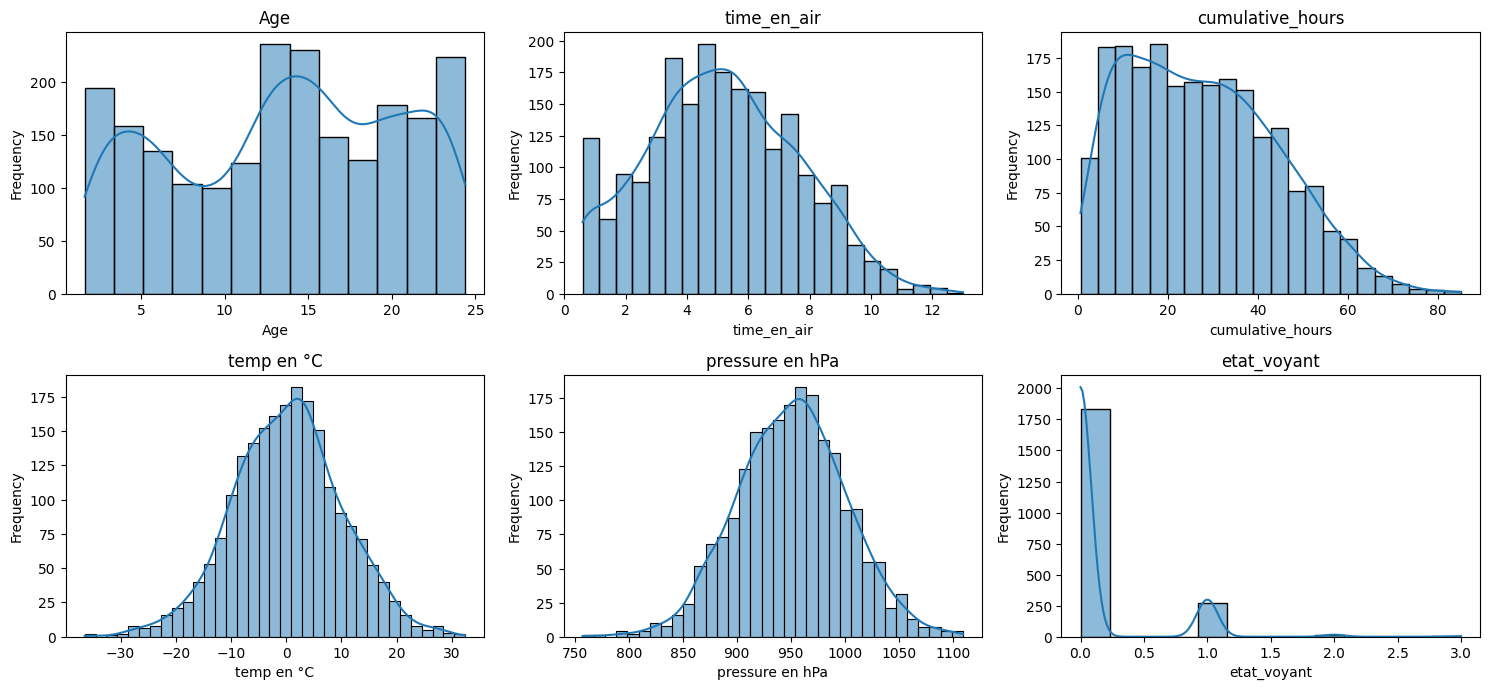

In [16]:
numerical_columns = df_logs_vols.select_dtypes(include= 'number').columns

grid_size = (3, 3) 

plt.figure(figsize=(15, 10))

for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(grid_size[0], grid_size[1], idx)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    sns.histplot(df_logs_vols[column], kde=True)
    plt.tight_layout()

plt.show()

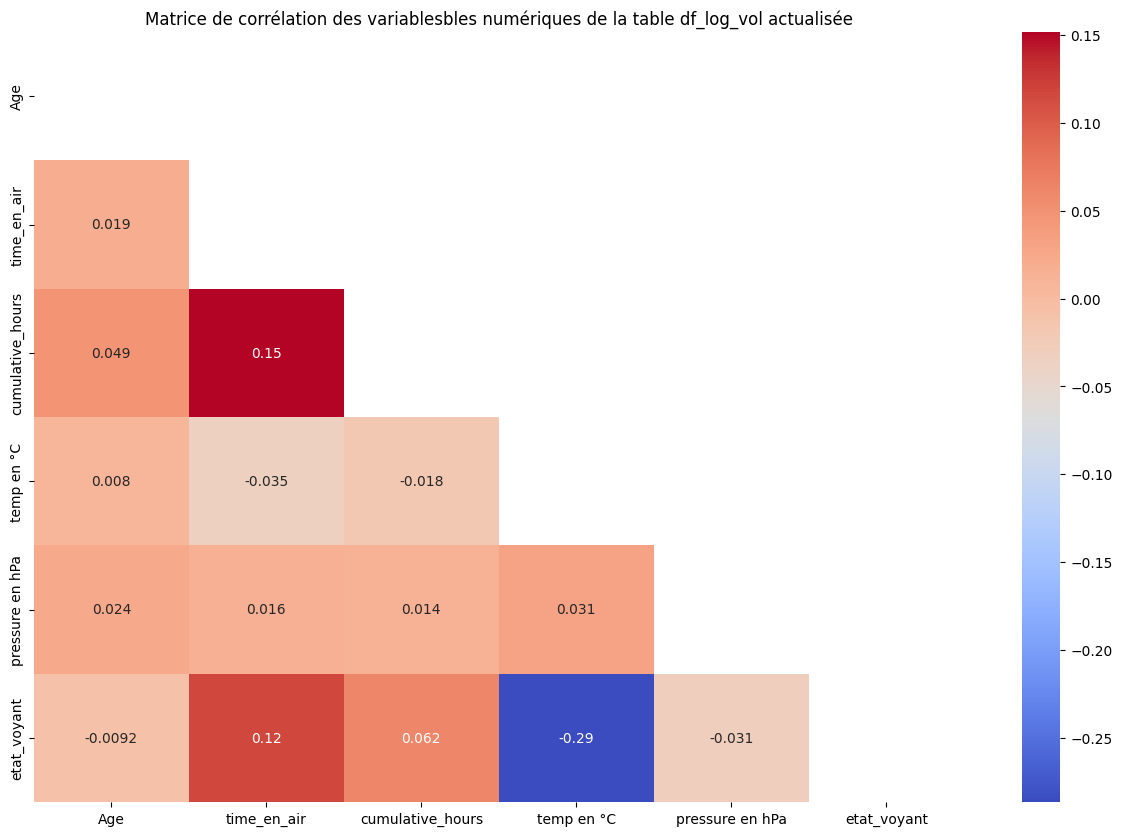

In [17]:
plt.figure(figsize=(15,10))

mumeric_columns = df_logs_vols.select_dtypes(include=['number']).columns
matrix = df_logs_vols[mumeric_columns].corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask = mask)
plt.title('Matrice de corrélation des variablesbles numériques de la table df_log_vol actualisée')
plt.show()

# ML :  logistic regression

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [19]:
df_logs_vols.head(5)

,ref_vol,id_aero,measure_day,first_service_date,Age,time_en_air,cumulative_hours,temp en °C,pressure en hPa,etat_voyant
0,V07679725,B767_4924,2024-06-02,2005-07-29,18.91,7.0,7.0,-5.7,930.6,0
1,V02564879,B747_3165,2024-06-02,2004-12-16,19.53,5.1,5.1,0.9,950.6,0
2,V07933973,B757_2518,2024-06-02,2006-05-09,18.13,7.7,7.7,-6.2,975.5,3
3,V02230187,A340_1047,2024-06-02,2017-07-30,6.91,6.1,6.1,-25.3,945.1,1
4,V09071213,B757_6806,2024-06-02,2006-08-10,17.88,4.5,4.5,11.1,931.3,0


In [20]:
X = df_logs_vols[['id_aero', 'Age', 'cumulative_hours', 'temp en °C', 'pressure en hPa']]
y = df_logs_vols['etat_voyant']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
numerical_columns = ['Age', 'cumulative_hours', 'temp en °C', 'pressure en hPa']
categorical_columns = ['id_aero']

In [23]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
                    ]
)

In [24]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['id_aero']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'cumulative_hours',
                                                   'temp en °C',
                                                   'pressure en hPa'])])),
                ('classifier', LogisticRegression())])

In [25]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['id_aero']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'cumulative_hours',
                                                   'temp en °C',
                                                   'pressure en hPa'])])),
                ('classifier', LogisticRegression())])

In [26]:
y_pred = pipeline.predict(X_test)

# LR Scores

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       360
           1       1.00      0.15      0.25        62
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.87       426
   macro avg       0.47      0.29      0.30       426
weighted avg       0.88      0.87      0.82       426



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [28]:
print('train score of logistic regression is :', pipeline.score(X_train, y_train))
print('test score of logistic regression is : ', pipeline.score(X_test, y_test))

train score of logistic regression is : 0.9012925969447708
test score of logistic regression is :  0.8661971830985915


In [29]:
matrix = confusion_matrix(y_test, y_pred)

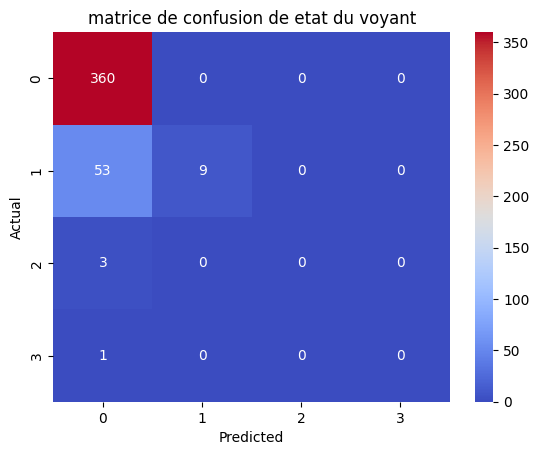

In [30]:
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('matrice de confusion de etat du voyant')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
df_logs_vols['predict_etat_voyant'] = pipeline.predict(X)

In [32]:
df_logs_vols

,ref_vol,id_aero,measure_day,first_service_date,Age,time_en_air,cumulative_hours,temp en °C,pressure en hPa,etat_voyant,predict_etat_voyant
0,V07679725,B767_4924,2024-06-02,2005-07-29,18.91,7.0,7.0,-5.7,930.6,0,0
1,V02564879,B747_3165,2024-06-02,2004-12-16,19.53,5.1,5.1,0.9,950.6,0,0
2,V07933973,B757_2518,2024-06-02,2006-05-09,18.13,7.7,7.7,-6.2,975.5,3,0
3,V02230187,A340_1047,2024-06-02,2017-07-30,6.91,6.1,6.1,-25.3,945.1,1,1
4,V09071213,B757_6806,2024-06-02,2006-08-10,17.88,4.5,4.5,11.1,931.3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2123,V08726632,A380_0710,2024-06-23,2021-10-17,2.69,5.6,70.0,-24.5,871.5,1,0
2124,V00567782,E175_5414,2024-06-23,2021-07-14,2.95,9.3,61.2,16.6,937.2,0,0
2125,V03348107,A320_2497,2024-06-23,2012-01-31,12.40,3.0,48.7,2.7,977.0,0,0
2126,V05253489,CRJ700_0969,2024-06-23,2003-01-25,21.42,0.6,51.5,-0.7,992.5,0,0


In [33]:
df_logs_vols['etat_voyant'].value_counts()

etat_voyant
0    1836
1     273
2      15
3       4
Name: count, dtype: int64

In [34]:
df_logs_vols['predict_etat_voyant'].value_counts()

predict_etat_voyant
0    2055
1      73
Name: count, dtype: int64

# ML : Random forest classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [36]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['id_aero']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'cumulative_hours',
                                                   'temp en °C',
                                                   'pressure en hPa'])])),
                ('classifier', RandomForestClassifier())])

In [37]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['id_aero']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'cumulative_hours',
                                                   'temp en °C',
                                                   'pressure en hPa'])])),
                ('classifier', RandomForestClassifier())])

In [38]:
y_pred = pipeline.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       360
           1       1.00      0.87      0.93        62
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.97       426
   macro avg       0.49      0.47      0.48       426
weighted avg       0.96      0.97      0.97       426



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Scores RFC

In [40]:
print('train score of random forest classifier is :', pipeline.score(X_train, y_train))
print('test score of random foreste classifier is : ', pipeline.score(X_test, y_test))

train score of random forest classifier is : 1.0
test score of random foreste classifier is :  0.971830985915493


In [41]:
matrix = confusion_matrix(y_test, y_pred)

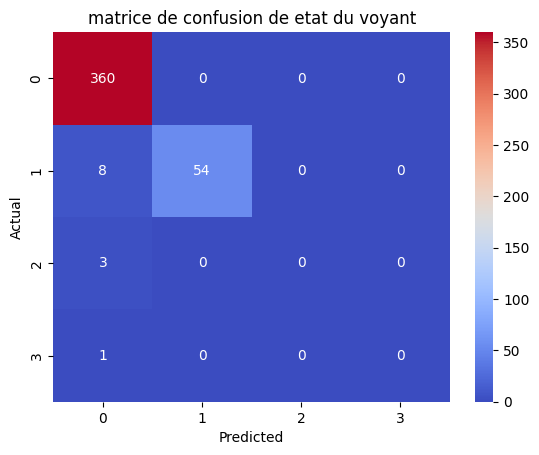

In [42]:
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('matrice de confusion de etat du voyant')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
df_logs_vols['etat_voyant'].value_counts()

etat_voyant
0    1836
1     273
2      15
3       4
Name: count, dtype: int64

In [44]:
df_logs_vols['predict_etat_voyant'].value_counts()

predict_etat_voyant
0    2055
1      73
Name: count, dtype: int64